In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas
from datetime import date
from matplotlib.colors import ListedColormap
from matplotlib.cm import ScalarMappable
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.patches import Rectangle
import time

%run ../global_variables.py ./
%run ../global_functions.py ./

This notebook compute 3 performance metrics (NSE, PBIAS and correlation) for given datasets and a selection of basins. Part 1 selects the basin, the datasets and run through all of them while saving results. Part 2 plots results.

<div class="alert alert-block alert-info">
There is no need to run Part 1, results are already saved. You can jump to part 2 to plot performance tables.
</div>

# 1. Compute performance matrices for selected datasets and basins

We select the basins we want to study. `NB_RUNOFF` is the number of runoff stations from [GRDC](https://www.bafg.de/SharedDocs/ExterneLinks/GRDC/grdc_stations_ftp.html) operating at least 1 year between 2003 and 2017, inside each basin.

In [7]:
#basins=load_basins_data()

#basins=geopandas.read_file('../datasets/basins/amazon_subbasins.shp')
basins=geopandas.read_file("../datasets/basins/basins_with_approx_climate_zones.shp")
basins.set_index("NAME",inplace=True)
basins.drop(['CONTINENT', 'OCEAN', 'CLIMATE_AR','COLOR_HEX'],axis=1,inplace=True)
basins.columns=['RASTAREA','MAIN_CLIMATE','geometry']

In [8]:
Nbasins=basins.shape[0]
print("You selected {} basins, among which \n {} belong to equatorial zone \n {} to arid zone \n {} to warm temperate zone \n {} to snow zone \n {} to polar zone".format(Nbasins,
    basins.loc[basins['MAIN_CLIMATE']=='A'].shape[0],
    basins.loc[basins['MAIN_CLIMATE']=='B'].shape[0],
    basins.loc[basins['MAIN_CLIMATE']=='C'].shape[0],
    basins.loc[basins['MAIN_CLIMATE']=='D'].shape[0],
    basins.loc[basins['MAIN_CLIMATE']=='E'].shape[0]))

You selected 189 basins, among which 
 38 belong to equatorial zone 
 57 to arid zone 
 37 to warm temperate zone 
 53 to snow zone 
 4 to polar zone


We plot selected_basins

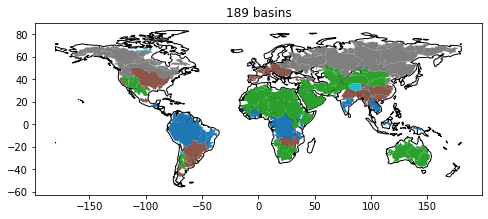

In [9]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world.drop([159,22,23],inplace=True) # Antarctica, Greenland,Seven seas (tiny islands Indian ocean)

fig, ax = plt.subplots(figsize=(8,5))
ax.set_aspect('equal')
world.plot(ax=ax, color='white', edgecolor='black')
basins.plot(ax=ax,column='MAIN_CLIMATE')
ax.set_title("{} basins".format(basins.shape[0]))
plt.show()

List of datasets available for each hydrological variable

In [10]:
list_data_P=['CPC','CRU','ERA5_Land','GLDAS20','GPCC','GPCP','GPM','JRA55','MERRA2','MSWEP','TRMM']
list_data_ET=['ERA5_Land','FLUXCOM','GLEAM','GLDAS20_NOAH36','GLDAS20_CLSM25','GLDAS20_VIC412',
              'GLDAS21_NOAH36','GLDAS21_CLSM25','GLDAS21_VIC412',
              'GLDAS22_CLSM25','JRA55',
              'MERRA2','MOD16','SSEBop']

list_data_R=['ERA5_Land','GLDAS20_NOAH36','GLDAS20_CLSM25','GLDAS20_VIC412',
             'GLDAS21_NOAH36','GLDAS21_CLSM25','GLDAS21_VIC412',
             'GLDAS22_CLSM25','JRA55',
             'GRUN','MERRA2']
#list_data_TWS=['GRACE_CSR_mascons','GRACE_JPL_mascons','GRACE_CSR_grid','GRACE_ITSG_grid']
data_TWS='GRACE_CSR_mascons'

## Computation for all hydrological datasets, over selected basins + performance metrics saved

Is it the first time we run the code with these parameters ?

In [11]:
first_time=True

In order to compare datasets coherently, the analysis is restricted to the period 2003-2014 where all datasets are available. 

In [12]:
min_year=2003
max_year=2014
if min_year==2003:
    if max_year==2014:
        time_idx=pd.date_range(date(min_year,3,1),date(max_year,12,1),freq='SM')[::2]
    else:
        time_idx=pd.date_range(date(min_year,3,1),date(max_year+1,1,1),freq='SM')[::2]
elif max_year==2014:
    time_idx=pd.date_range(date(min_year,1,1),date(max_year,12,1),freq='SM')[::2]
else:
    time_idx=pd.date_range(date(min_year,1,1),date(max_year+1,1,1),freq='SM')[::2]

We initialize the results dataframe

In [13]:
datasets=[]
for d_P in list_data_P:
    for d_ET in list_data_ET:
        for d_R in list_data_R:
            datasets.append('P_{}_ET_{}_R_{}_TWS_{}'.format(d_P,d_ET,d_R,data_TWS))

In [14]:
len(datasets)

1694

In [15]:
if first_time: 
    Ndatasets=0
    df=pd.DataFrame(np.nan*np.ones((basins.shape[0],len(datasets))),
                    index=basins.index,columns=datasets)
    deseason_correlation_tab=df.copy()
    correlation_tab=df.copy()
    PBIAS_tab=df.copy()
    NSE_tab=df.copy()
    NSE_cyclic_tab=df.copy()
    RMSE_tab=df.copy()  
    GRACE_uncertainty_tab=df.copy()
else: # if we want to add new datasets to existing tabs
    Ndatasets=1694
    correlation_tab=pd.read_csv("../results/water_budget/correlation_tab_{}_{}_{}basins_{}datasets_{}.csv".format(min_year,
                                                                    max_year,Nbasins,nb_datasets,data_TWS),index_col=[0])
    PBIAS_tab=pd.read_csv("../results/water_budget/correlation_tab_{}_{}_{}basins_{}datasets_{}.csv".format(min_year,
                                                                    max_year,Nbasins,nb_datasets,data_TWS),index_col=[0])
    NSE_tab=pd.read_csv("../results/water_budget/correlation_tab_{}_{}_{}basins_{}datasets_{}.csv".format(min_year,
                                                                    max_year,Nbasins,nb_datasets,data_TWS),index_col=[0])
    NSE_cyclic_tab=pd.read_csv("../results/water_budget/correlation_tab_{}_{}_{}basins_{}datasets_{}.csv".format(min_year,
                                                                    max_year,Nbasins,nb_datasets,data_TWS),index_col=[0])  
    RMSE_tab=pd.read_csv("../results/water_budget/correlation_tab_{}_{}_{}basins_{}datasets_{}.csv".format(min_year,
                                                                    max_year,Nbasins,nb_datasets,data_TWS),index_col=[0])   
    GRACE_uncertainty_tab=pd.read_csv("../results/water_budget/correlation_tab_{}_{}_{}basins_{}datasets_{}.csv".format(min_year,
                                                                    max_year,Nbasins,nb_datasets,data_TWS),index_col=[0])

For each dataset, we load the basin timeseries computed by the notebook `Save basins data`, compute the net accumulation and calculate performance metrics. Each performance is saved in the corresponding table.

In [18]:
TWS_month=pd.read_csv('../results/hydrology/TWS_{}_monthly_filtered.csv'.format(data_TWS),index_col=[0])
time_TWS=pd.to_datetime(TWS_month.columns.str[4+len(data_TWS):])

if data_TWS=='GRACE_JPL_mascons':
    dTWS_month=pd.read_csv('../results/hydrology/TWS_uncertainty_{}_monthly_filtered.csv'.format(data_TWS),index_col=[0])

i=0
for data_P in list_data_P:  
    P_month=pd.read_csv('../results/hydrology/P_{}_monthly_filtered.csv'.format(data_P),index_col=[0])
    time_P=pd.to_datetime(P_month.columns.str[2+len(data_P):])
    
    for data_ET in list_data_ET:   
        ET_month=pd.read_csv('../results/hydrology/ET_{}_monthly_filtered.csv'.format(data_ET),index_col=[0])
        time_ET=pd.to_datetime(ET_month.columns.str[3+len(data_ET):])
        
        for data_R in list_data_R:   
            R_month=pd.read_csv('../results/hydrology/R_{}_monthly_filtered.csv'.format(data_R),index_col=[0])
            time_R=pd.to_datetime(R_month.columns.str[2+len(data_R):]) 
            
            i+=1
            print("dataset {}/{}".format(i,len(datasets)))

            for basin_name in basins.index:
                P_filter=P_month.loc[basin_name,['P_{} {}'.format(data_P,d.date()) for d in time_idx]]
                ET_filter=ET_month.loc[basin_name,['ET_{} {}'.format(data_ET,d.date()) for d in time_idx]]
                R_filter=R_month.loc[basin_name,['R_{} {}'.format(data_R,d.date()) for d in time_idx]]
                TWSC_filter=TWS_month.loc[basin_name,['TWS_{} {}'.format(data_TWS,d.date()) for d in time_idx]]
                if data_TWS=='GRACE_JPL_mascons':
                    dTWSC_filter=dTWS_month.loc[basin_name,['TWS_uncertainty_{} {}'.format(data_TWS,d.date()) for d in time_idx]]

                fillingP=(np.sum(np.isnan(P_filter))==0)
                fillingET=(np.sum(np.isnan(ET_filter))==0)
                fillingR=(np.sum(np.isnan(R_filter))==0)
                fillingTWS=(np.sum(np.isnan(TWSC_filter))==0)

                if fillingP&fillingET&fillingR&fillingTWS: # if this basin is entirely covered by all datasets, proceed, otherwise the loop ends
                    A_filter=pd.Series(P_filter.values-ET_filter.values-R_filter.values,index=time_idx)
                    TWSC_filter.index=time_idx
                    if data_TWS=='GRACE_JPL_mascons':
                        dTWSC_filter.index=time_idx
                    
                    # compute performance metrics
                    col='P_{}_ET_{}_R_{}_TWS_{}'.format(data_P,data_ET,data_R,data_TWS)
                    
                    corr=A_filter.corr(TWSC_filter)
                    correlation_tab.loc[basin_name,col]=corr

                    PBIAS=percentage_bias(A_filter,TWSC_filter)
                    PBIAS_tab.loc[basin_name,col]=PBIAS

                    NSE=compute_NSE(A_filter,TWSC_filter)
                    NSE_tab.loc[basin_name,col]=NSE
                    
                    NSE_cyclic=compute_cyclic_NSE(A_filter,TWSC_filter)
                    NSE_cyclic_tab.loc[basin_name,col]=NSE_cyclic
                    
                    RMSE=compute_RMSE(A_filter,TWSC_filter)
                    RMSE_tab.loc[basin_name,col]=RMSE
                    
                    if data_TWS=='GRACE_JPL_mascons':
                        GRACE_uncertainty=100*np.sum((A_filter<=TWSC_filter+dTWSC_filter)&(A_filter>=TWSC_filter-dTWSC_filter))/A_filter.shape[0]
                        GRACE_uncertainty_tab.loc[basin_name,col]=GRACE_uncertainty
                    
                    deseason_TWSC=deseasone(TWSC_filter)
                    deseason_A=deseasone(A_filter)
                    deseason_correlation_tab.loc[basin_name,col]=deseason_A.corr(deseason_TWSC)
                    
                    
#nb_datasets=Ndatasets                    
#nb_datasets=Ndatasets+len(datasets) # if we added new datasets
nb_datasets=correlation_tab.shape[1]

correlation_tab.to_csv("../results/water_budget/correlation_tab_{}_{}_{}basins_{}datasets_{}.csv".format(min_year,
                                                                        max_year,Nbasins,nb_datasets,data_TWS))
deseason_correlation_tab.to_csv("../results/water_budget/deseason_correlation_tab_{}_{}_{}basins_{}datasets_{}.csv".format(min_year,
                                                                        max_year,Nbasins,nb_datasets,data_TWS))
PBIAS_tab.to_csv("../results/water_budget/PBIAS_tab_{}_{}_{}basins_{}datasets_{}.csv".format(min_year,
                                                                        max_year,Nbasins,nb_datasets,data_TWS))
NSE_tab.to_csv("../results/water_budget/NSE_tab_{}_{}_{}basins_{}datasets_{}.csv".format(min_year,
                                                                        max_year,Nbasins,nb_datasets,data_TWS))
NSE_cyclic_tab.to_csv("../results/water_budget/NSE_cyclic_tab_{}_{}_{}basins_{}datasets_{}.csv".format(min_year,
                                                                        max_year,Nbasins,nb_datasets,data_TWS))
RMSE_tab.to_csv("../results/water_budget/RMSE_tab_{}_{}_{}basins_{}datasets_{}.csv".format(min_year,
                                                                        max_year,Nbasins,nb_datasets,data_TWS))
if data_TWS=='GRACE_JPL_mascons':
    GRACE_uncertainty_tab.to_csv("../results/water_budget/GRACE_uncertainty_tab_{}_{}_{}basins_{}datasets_{}.csv".format(min_year,
                                                                        max_year,Nbasins,nb_datasets,data_TWS))
first_time=False

dataset 1/1694
dataset 2/1694
dataset 3/1694
dataset 4/1694
dataset 5/1694
dataset 6/1694
dataset 7/1694
dataset 8/1694
dataset 9/1694
dataset 10/1694
dataset 11/1694
dataset 12/1694
dataset 13/1694
dataset 14/1694
dataset 15/1694
dataset 16/1694
dataset 17/1694
dataset 18/1694
dataset 19/1694
dataset 20/1694
dataset 21/1694
dataset 22/1694
dataset 23/1694
dataset 24/1694
dataset 25/1694
dataset 26/1694
dataset 27/1694
dataset 28/1694
dataset 29/1694
dataset 30/1694
dataset 31/1694
dataset 32/1694
dataset 33/1694
dataset 34/1694
dataset 35/1694
dataset 36/1694
dataset 37/1694
dataset 38/1694
dataset 39/1694
dataset 40/1694
dataset 41/1694
dataset 42/1694
dataset 43/1694
dataset 44/1694
dataset 45/1694
dataset 46/1694
dataset 47/1694
dataset 48/1694
dataset 49/1694
dataset 50/1694
dataset 51/1694
dataset 52/1694
dataset 53/1694
dataset 54/1694
dataset 55/1694
dataset 56/1694
dataset 57/1694
dataset 58/1694
dataset 59/1694
dataset 60/1694
dataset 61/1694
dataset 62/1694
dataset 63/1694
d

dataset 490/1694
dataset 491/1694
dataset 492/1694
dataset 493/1694
dataset 494/1694
dataset 495/1694
dataset 496/1694
dataset 497/1694
dataset 498/1694
dataset 499/1694
dataset 500/1694
dataset 501/1694
dataset 502/1694
dataset 503/1694
dataset 504/1694
dataset 505/1694
dataset 506/1694
dataset 507/1694
dataset 508/1694
dataset 509/1694
dataset 510/1694
dataset 511/1694
dataset 512/1694
dataset 513/1694
dataset 514/1694
dataset 515/1694
dataset 516/1694
dataset 517/1694
dataset 518/1694
dataset 519/1694
dataset 520/1694
dataset 521/1694
dataset 522/1694
dataset 523/1694
dataset 524/1694
dataset 525/1694
dataset 526/1694
dataset 527/1694
dataset 528/1694
dataset 529/1694
dataset 530/1694
dataset 531/1694
dataset 532/1694
dataset 533/1694
dataset 534/1694
dataset 535/1694
dataset 536/1694
dataset 537/1694
dataset 538/1694
dataset 539/1694
dataset 540/1694
dataset 541/1694
dataset 542/1694
dataset 543/1694
dataset 544/1694
dataset 545/1694
dataset 546/1694
dataset 547/1694
dataset 548/16

dataset 972/1694
dataset 973/1694
dataset 974/1694
dataset 975/1694
dataset 976/1694
dataset 977/1694
dataset 978/1694
dataset 979/1694
dataset 980/1694
dataset 981/1694
dataset 982/1694
dataset 983/1694
dataset 984/1694
dataset 985/1694
dataset 986/1694
dataset 987/1694
dataset 988/1694
dataset 989/1694
dataset 990/1694
dataset 991/1694
dataset 992/1694
dataset 993/1694
dataset 994/1694
dataset 995/1694
dataset 996/1694
dataset 997/1694
dataset 998/1694
dataset 999/1694
dataset 1000/1694
dataset 1001/1694
dataset 1002/1694
dataset 1003/1694
dataset 1004/1694
dataset 1005/1694
dataset 1006/1694
dataset 1007/1694
dataset 1008/1694
dataset 1009/1694
dataset 1010/1694
dataset 1011/1694
dataset 1012/1694
dataset 1013/1694
dataset 1014/1694
dataset 1015/1694
dataset 1016/1694
dataset 1017/1694
dataset 1018/1694
dataset 1019/1694
dataset 1020/1694
dataset 1021/1694
dataset 1022/1694
dataset 1023/1694
dataset 1024/1694
dataset 1025/1694
dataset 1026/1694
dataset 1027/1694
dataset 1028/1694
da

dataset 1429/1694
dataset 1430/1694
dataset 1431/1694
dataset 1432/1694
dataset 1433/1694
dataset 1434/1694
dataset 1435/1694
dataset 1436/1694
dataset 1437/1694
dataset 1438/1694
dataset 1439/1694
dataset 1440/1694
dataset 1441/1694
dataset 1442/1694
dataset 1443/1694
dataset 1444/1694
dataset 1445/1694
dataset 1446/1694
dataset 1447/1694
dataset 1448/1694
dataset 1449/1694
dataset 1450/1694
dataset 1451/1694
dataset 1452/1694
dataset 1453/1694
dataset 1454/1694
dataset 1455/1694
dataset 1456/1694
dataset 1457/1694
dataset 1458/1694
dataset 1459/1694
dataset 1460/1694
dataset 1461/1694
dataset 1462/1694
dataset 1463/1694
dataset 1464/1694
dataset 1465/1694
dataset 1466/1694
dataset 1467/1694
dataset 1468/1694
dataset 1469/1694
dataset 1470/1694
dataset 1471/1694
dataset 1472/1694
dataset 1473/1694
dataset 1474/1694
dataset 1475/1694
dataset 1476/1694
dataset 1477/1694
dataset 1478/1694
dataset 1479/1694
dataset 1480/1694
dataset 1481/1694
dataset 1482/1694
dataset 1483/1694
dataset 14

# 2. Results

## 2.1. Functions to plot nice tables

Function to draw column separation between datasets.

In [12]:
def find_separation_datasets(datasets):
    # name of datasets
    data_P=[]
    data_ET=[]
    data_R=[]
    for data_name in datasets:
        iP=data_name.find('_ET')
        data_P.append(data_name[:iP])
        iET=data_name.find('_R',iP+1)
        data_ET.append(data_name[iP+1:iET])
        iR=data_name.find('_TWS',iET+1)
        data_R.append(data_name[iET+1:iR])
    
    sep_P=np.unique(data_P,return_index=True)[1]
    sep_P_unsorted=sep_P.copy()
    sep_P.sort()
    sep_ET=[]
    for i in range(len(sep_P)-1):
        sep_ET+=list(sep_P[i]+np.unique(data_ET[sep_P[i]:sep_P[i+1]],return_index=True)[1])
    sep_ET+=list(sep_P[-1]+np.unique(data_ET[sep_P[-1]:],return_index=True)[1])

    return data_P,data_ET,data_R,sep_P_unsorted,sep_ET

Grey hatched boxes are shown in the performance tabs in each basin where at least 1 dataset is lacking. 

## 2.2. NSE over all basins and some datasets combinations

In [56]:
%matplotlib notebook

basins=load_basins_data()
Nbasins=basins.shape[0]
Ndatasets=1430
data_TWS='GRACE_JPL_mascons'

NSE_tab=pd.read_csv("../results/water_budget/NSE_tab_{}basins_{}datasets_{}.csv".format(Nbasins,Ndatasets,data_TWS),index_col=[0])

Extract the list of datasets combinations from the columns names and find the list of datasets used for each hydrological variable.

In [14]:
datasets=NSE_tab.columns
data_P,data_ET,data_R,sep_P,sep_ET=find_separation_datasets(datasets)

In [15]:
threshold=0.5
print('maximum NSE >= {} in {} basins ({:.0f}% of {})'.format(threshold,
                        np.sum(np.nanmax(NSE_tab,axis=1)>=threshold),
                        100*np.sum(np.nanmax(NSE_tab,axis=1)>=threshold)/NSE_tab.shape[0],
                        NSE_tab.shape[0]))

maximum NSE >= 0.5 in 134 basins (69% of 194)


Plot the best NSE over all combinations

<IPython.core.display.Javascript object>


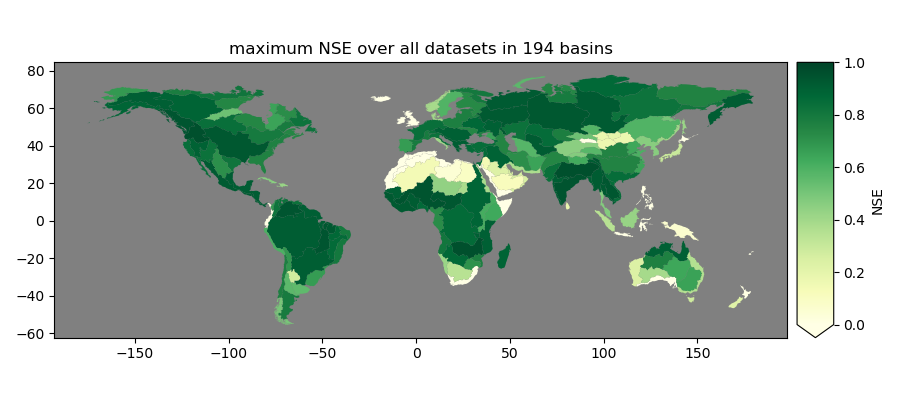

In [16]:
basins_plot=basins.loc[NSE_tab.index].copy()
basins_plot['max NSE']=np.nanmax(NSE_tab,axis=1)

fig, ax = plt.subplots(figsize=(9,4))
ax.set_aspect('equal')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
#basins.plot(ax=ax,color='white',edgecolor='black',linewidth=0.5)
basins_plot.plot(ax=ax,column='max NSE',
                 cmap=plt.cm.get_cmap('YlGn'),
                 vmin=0,vmax=1,
                 legend=True,cax=cax,
                legend_kwds={'label': "NSE",
                              'extend':'min'
                          },)
ax.set_facecolor("grey")
ax.set_title('maximum NSE over all datasets in {} basins'.format(NSE_tab.shape[0]))
plt.tight_layout()
plt.show()

NSE with a given combination

<IPython.core.display.Javascript object>


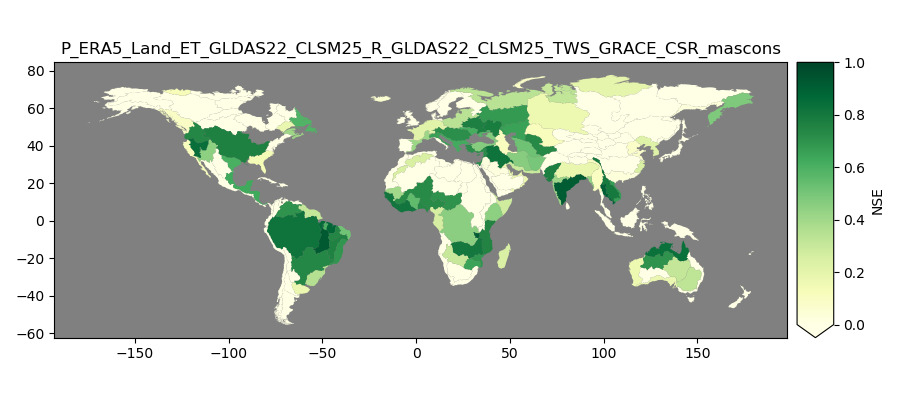

In [33]:
#comb='P_ERA5_Land_ET_ERA5_Land_R_ERA5_Land_TWS_{}'.format(data_TWS)
comb='P_ERA5_Land_ET_GLDAS22_CLSM25_R_GLDAS22_CLSM25_TWS_{}'.format(data_TWS)

basins_plot[comb]=NSE_tab[comb]

fig, ax = plt.subplots(figsize=(9,4))
ax.set_aspect('equal')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
#basins.plot(ax=ax,color='white',edgecolor='black',linewidth=0.5)
basins_plot.plot(ax=ax,column=comb,
                 cmap=plt.cm.get_cmap('YlGn'),
                 vmin=0,vmax=1,
                 legend=True,cax=cax,
                legend_kwds={'label': "NSE",
                              'extend':'min'
                          },)
ax.set_facecolor("grey")
ax.set_title(comb)
plt.tight_layout()
plt.show()

In [8]:
np.sum(NSE_tab[comb]>0.7)

71

In [14]:
np.sum(basins_plot['max NSE - '+comb]<0.2)

147

<IPython.core.display.Javascript object>


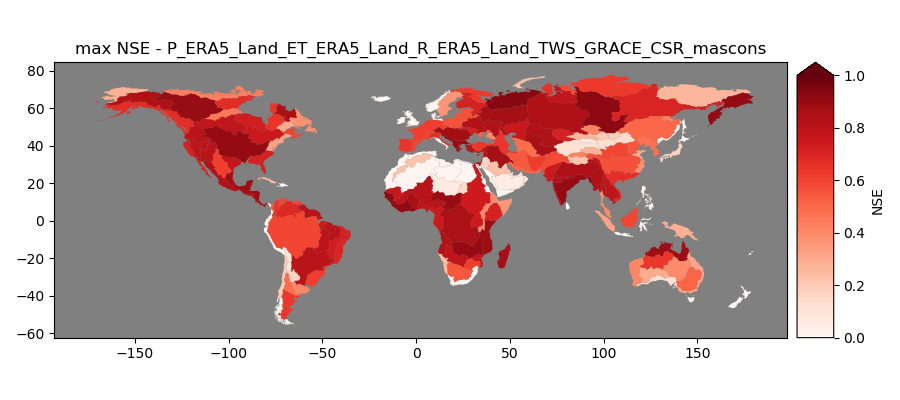

In [12]:
comb='P_ERA5_Land_ET_ERA5_Land_R_ERA5_Land_TWS_{}'.format(data_TWS)

basins_plot['max NSE - '+comb]=basins_plot['max NSE']-NSE_tab[comb]

fig, ax = plt.subplots(figsize=(9,4))
ax.set_aspect('equal')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
#basins.plot(ax=ax,color='white',edgecolor='black',linewidth=0.5)
basins_plot.plot(ax=ax,column=comb,
                 cmap=plt.cm.get_cmap('Reds'),
                 vmin=0,vmax=1,
                 legend=True,cax=cax,
                legend_kwds={'label': "NSE",
                             'extend':'max'
                          },)
ax.set_facecolor("grey")
ax.set_title('max NSE - '+comb)
plt.tight_layout()
plt.show()

In [10]:
np.sum(basins_plot['max NSE - '+comb]<0.1)

103

## 2.3. Statistics to rank datasets combinations

Combinations are ranked per decreasing number of basins performing at least good (NSE>=0.5)

In [45]:
full_datasets=[]
for d_P in ['CPC','CRU','ERA5_Land','GPCC','GPCP','GPM','MERRA2','MSWEP']:
    for d_ET in ['ERA5_Land','GLDAS20_CLSM25','GLDAS21_CLSM25',
                 'GLDAS20_NOAH36','GLDAS21_NOAH36','GLDAS20_VIC412','GLDAS21_VIC412',
                 'GLDAS22_CLSM25','GLEAM','MERRA2','SSEBop']:
        for d_R in ['ERA5_Land','GLDAS20_CLSM25','GLDAS21_CLSM25',
                 'GLDAS20_NOAH36','GLDAS21_NOAH36','GLDAS20_VIC412','GLDAS21_VIC412',
                 'GLDAS22_CLSM25','GRUN','MERRA2']:
            full_datasets.append('P_{}_ET_{}_R_{}_TWS_{}'.format(d_P,d_ET,d_R,data_TWS))
full_basins=NSE_tab.index[(np.sum(np.isnan(NSE_tab[full_datasets]),axis=1)==0)]
full_basins.shape

(133,)

Use all datasets but with only non missing basins

In [10]:
full_basins=NSE_tab.index[(np.sum(np.isnan(NSE_tab[datasets]),axis=1)==0)]
full_datasets=datasets
full_basins.shape

(70,)

To include all datasets in the ranking

In [17]:
full_basins=NSE_tab.index
full_datasets=datasets
full_basins.shape

(194,)

<IPython.core.display.Javascript object>


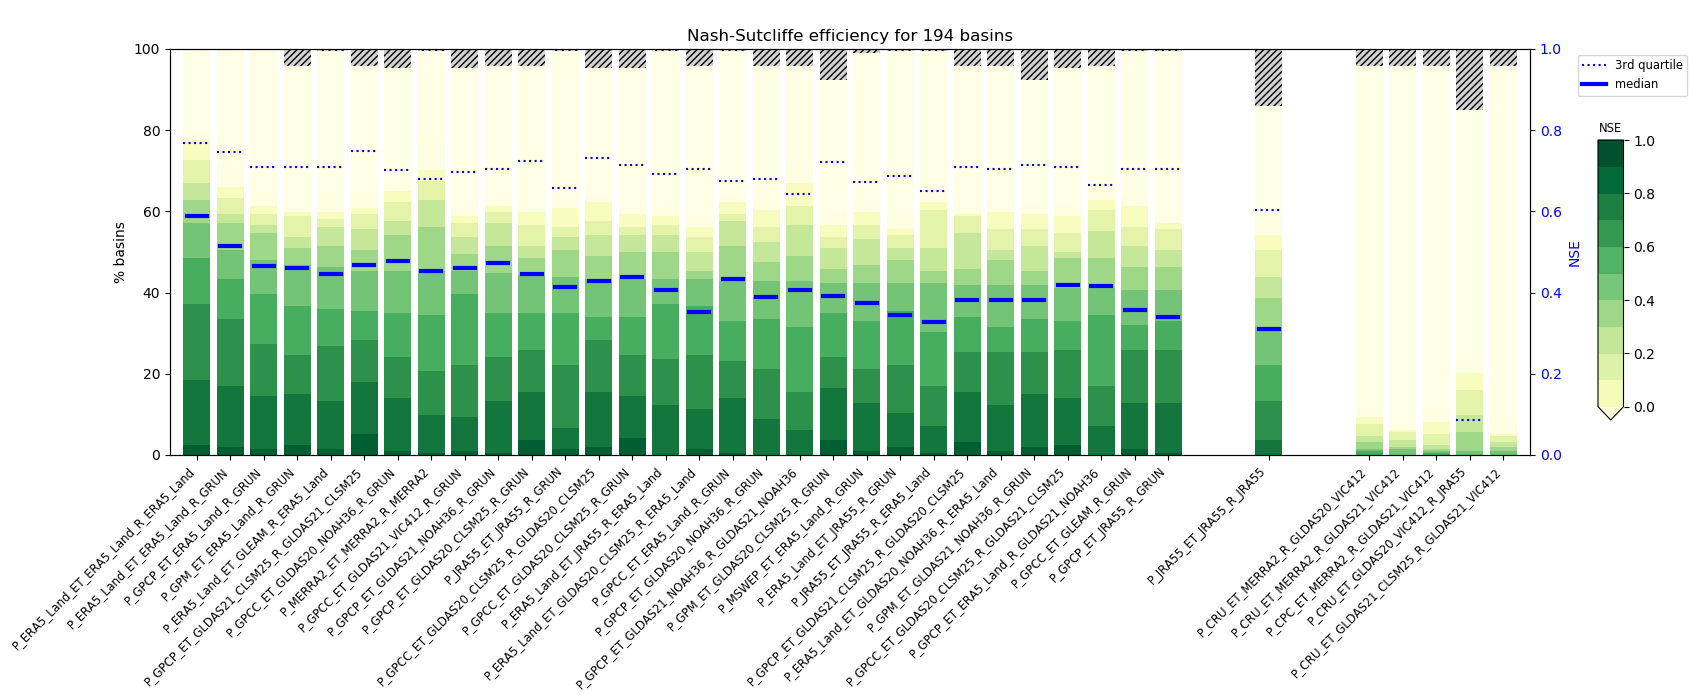

In [19]:
limitsNSE=list(np.arange(0.9,-0.1,-0.1))
my_cmap = plt.cm.get_cmap('YlGn')

# compute the number of basins in each NSE category for all datasets
select_NSE_tab=NSE_tab.loc[full_basins,full_datasets]
nb_very_good=np.sum(select_NSE_tab>=0.75,axis=0)
nb_good=np.sum(select_NSE_tab>=0.5,axis=0)

datasets_perf=nb_very_good.to_frame(name='very good')
datasets_perf['good']=nb_good

# sort datasets combinations per decreasing number of basins at least good
plot_good=30
plot_bad=5
sorted_datasets=list(datasets_perf.sort_values(by=['good','very good'],ascending=False).index[:plot_good])
xdatasets=list(np.arange(plot_good))
for my_combination in ['P_ERA5_Land_ET_ERA5_Land_R_ERA5_Land_TWS_{}'.format(data_TWS),
                       'P_MERRA2_ET_MERRA2_R_MERRA2_TWS_{}'.format(data_TWS),
                      'P_JRA55_ET_JRA55_R_JRA55_TWS_{}'.format(data_TWS)]:
    if not(my_combination in sorted_datasets):
        sorted_datasets.append(my_combination)
        xdatasets.append(xdatasets[-1]+3)

sorted_datasets+=list(datasets_perf.sort_values(by=['good','very good'],ascending=False).index[-plot_bad:])
xdatasets+=list(np.arange(xdatasets[-1]+3,xdatasets[-1]+3+plot_bad))

select_NSE_tab=select_NSE_tab[sorted_datasets]
nb_basins=select_NSE_tab.shape[0]
nb_datasets=select_NSE_tab.shape[1]

width=0.8

fig, ax1 = plt.subplots(figsize=(17,7))

bottom=np.zeros(nb_datasets)
for lim in limitsNSE:
    basinsNSE=100*np.sum(select_NSE_tab>=lim,axis=0)/nb_basins-bottom
    ax1.bar(xdatasets,basinsNSE,width,bottom=bottom,color=my_cmap(lim+0.01))
    bottom+=basinsNSE

# poorest performance
basinsNSE=100*np.sum(select_NSE_tab<lim,axis=0)/nb_basins
ax1.bar(xdatasets,basinsNSE,width,bottom=bottom,color=my_cmap(0))
bottom=bottom+basinsNSE

ax1.bar(xdatasets,100-bottom,width,
        bottom=bottom,color='lightgrey',hatch='/////')


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

# plot medians
for i,med in zip(xdatasets,select_NSE_tab.median(axis=0)):
    line1,=ax2.plot([i-(width-0.2)/2,i+(width-0.2)/2],[med,med],'b',linewidth=3)
    
for i,med in zip(xdatasets,select_NSE_tab.quantile(0.75,axis=0)):
    line2,=ax2.plot([i-(width)/2,i+(width)/2],[med,med],'b:')

ax2.legend([line2,line1],['3rd quartile','median'],loc='upper right', bbox_to_anchor=(1.12, 1.),fontsize='small')
ax2.set_ylim([0,1])
ax2.set_ylabel('NSE',color='b')
ax2.tick_params(axis='y', labelcolor='b')

ax1.set_xticks(xdatasets)
ax1.set_xticklabels(select_NSE_tab.columns.str[:-len(data_TWS)-5],rotation=45,ha='right',fontsize='small')
#plt.xticks(xdatasets,select_NSE_tab.columns.str[:-len(data_TWS)-5],rotation=90,fontsize='small')
ax1.set_xlim([-width,xdatasets[-1]+width])
ax1.set_ylim([0,100])

plt.title('Nash-Sutcliffe efficiency for {} basins'.format(nb_basins))
ax1.set_ylabel('% basins')  


fig.subplots_adjust(left=0.1,bottom=0.35, right=0.9, top=0.93)
cax = plt.axes([0.94, 0.4, 0.015, 0.4])
    
clb=fig.colorbar(
        ScalarMappable(cmap=plt.cm.get_cmap('YlGn'), norm=plt.Normalize(-0.1,1)),
        cax=cax,
        fraction=0.01,
        boundaries=[-0.1] + limitsNSE[::-1] + [1],  # Adding values for extensions.
        extend='min',
        ticks=[-0.1]+limitsNSE[::-1][::2]+[1],
        spacing='proportional',
    )
clb.ax.set_title('NSE',fontsize='small') 
#plt.tight_layout()
plt.show()

In [29]:
comb='P_ERA5_Land_ET_ERA5_Land_R_ERA5_Land_TWS_{}'.format(data_TWS)
100*np.sum(NSE_tab[comb]>=0.5)/NSE_tab.shape[0]

57.21649484536083

## Tables of performances per hydrological variable

In [5]:
def findnth(haystack, needle, n):
    parts= haystack.split(needle, n+1)
    if len(parts)<=n+1:
        return -1
    return len(haystack)-len(parts[-1])-len(needle)

In [6]:
def highlight_max(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = s == s.max()
    #return ['background-color: yellow' if v else '' for v in is_max]
    return ['font-weight: bold' if v else '' for v in is_max]

Tables of NSE distribution and percentage of basins in each performance category for all datasets

In [42]:
hydro_var_name='P'
method='all' # 'best' to compute percentage over the best combination, 'all' to compute over all combinations
#climate='all'
climate=[10] # 'all' to include all basins or a list between 1 and 18 to restrict to a given climate zone


if hydro_var_name=='P':
    list_data=pd.Index(np.unique(data_P)).str[len(hydro_var_name)+1:]
if hydro_var_name=='ET':
    list_data=pd.Index(np.unique(data_ET)).str[len(hydro_var_name)+1:]
if hydro_var_name=='R':
    list_data=pd.Index(np.unique(data_R)).str[len(hydro_var_name)+1:]

stats=pd.DataFrame(np.zeros((list_data.shape[0],7)),index=list_data,
                   columns=['median','1st quartile','3rd quartile','% very good','% good','% acceptable','% missing'])

for data in list_data:
    select_datasets=[i for i in datasets if '{}_{}'.format(hydro_var_name,data) in i]
    
    if climate=='all':
        select_NSE_tab=NSE_tab[select_datasets]
    else:
        select_NSE_tab=NSE_tab.loc[basins['CLIMATE'].isin(climate),select_datasets]
    #print('You selected {} basins'.format(select_NSE_tab.shape[0]))
    temp=select_NSE_tab.values.flatten()
    (nb_basins,nb_datasets)=select_NSE_tab.shape
    
    # do we want percentages over all basins or non-missing values ?
    #nb_nan=np.sum(np.isnan(temp))
    nb_nan=0
    
    stats.loc[data,'% missing']=100*np.sum(np.isnan(temp))/temp.shape[0]
    
    temp=temp[~np.isnan(temp)]
    stats.loc[data,'median']=np.median(temp)
    stats.loc[data,'1st quartile']=np.percentile(temp, 25, interpolation = 'midpoint') 
    stats.loc[data,'3rd quartile']=np.percentile(temp, 75, interpolation = 'midpoint') 
    if method=='best':
        stats.loc[data,'% very good']=100*np.sum(select_NSE_tab.max(axis=1)>=0.75)/(nb_basins)
        stats.loc[data,'% good']=100*np.sum(select_NSE_tab.max(axis=1)>=0.5)/(nb_basins)
        stats.loc[data,'% acceptable']=100*np.sum(select_NSE_tab.max(axis=1)>=0.2)/(nb_basins)
    elif method=='all':
        stats.loc[data,'% very good']=100*np.sum(temp>=0.75)/(nb_basins*nb_datasets-nb_nan)
        stats.loc[data,'% good']=100*np.sum(temp>=0.5)/(nb_basins*nb_datasets-nb_nan)
        stats.loc[data,'% acceptable']=100*np.sum(temp>=0.2)/(nb_basins*nb_datasets-nb_nan)

stats.style.apply(highlight_max).format("{:.2f}")

You selected 18 basins
You selected 18 basins
You selected 18 basins
You selected 18 basins
You selected 18 basins
You selected 18 basins
You selected 18 basins
You selected 18 basins
You selected 18 basins


,median,1st quartile,3rd quartile,% very good,% good,% acceptable,% missing
CPC,-0.28,-3.23,0.41,3.84,16.94,33.94,8.80
CRU,-1.17,-5.61,-0.18,0.00,1.67,8.66,8.80
ERA5_Land,-0.33,-2.38,0.40,4.49,17.69,31.99,8.80
GPCC,-0.05,-3.10,0.44,4.58,18.70,36.67,8.80
GPCP,-0.15,-3.83,0.40,3.06,16.62,33.43,8.80
GPM,-0.29,-3.91,0.30,2.36,12.78,29.12,8.80
MERRA2,-0.09,-2.83,0.49,4.68,21.76,37.41,8.80
MSWEP,-0.05,-3.52,0.48,3.84,20.37,36.48,13.89
TRMM,0.01,-2.20,0.44,3.06,14.95,31.06,24.54


Format latex tab with optimal values in bold

In [34]:
str_latex=stats.to_latex(float_format="%.2f")
columns_descr='{} & \\thead{median} & \\thead{1st quartile} &  \\thead{3rd quartile} &'
columns_descr+='\\thead{ \\% very good \\\\ (NSE $ \\ge 0.75 $) } &'
columns_descr+='\\thead{ \\% good \\\\ (NSE $ \\ge 0.5 $) } &'
columns_descr+='\\thead{ \\% acceptable \\\\ (NSE $ \\ge 0.2 $) } &'
columns_descr+='\\thead{ \\% poor \\\\ (NSE $ < 0.2 $) }  \\\\\n'
str_latex=str_latex[:str_latex.find('\\toprule')+9]+columns_descr+str_latex[str_latex.find('\\midrule'):]

for i,col in enumerate(stats.columns[:-1]):
    best_dataset=stats.index[stats[col].argmax()]
    
    ind=str_latex.find(best_dataset.replace('_','\_'))
    first_sep=findnth(str_latex[ind:],'&',i)+ind
    second_sep=findnth(str_latex[ind:],'&',i+1)+ind
    
    #print(best_dataset,first_sep,second_sep)
    
    #first_sep=str_latex.find('&',ind)
    #second_sep=str_latex.find('&',first_sep+1)
    
    str_latex=str_latex[:first_sep+1]+'\\textbf {'+str_latex[first_sep+1:second_sep].replace(" ", "") +'}'+str_latex[second_sep:]

# add the minimum for the last column
col=stats.columns[-1]
best_dataset=stats.index[stats[col].argmin()]
    
ind=str_latex.find(best_dataset.replace('_','\_'))
first_sep=findnth(str_latex[ind:],'&',i+1)+ind
second_sep=str_latex.find('\\',first_sep+1)
str_latex=str_latex[:first_sep+1]+'\\textbf {'+str_latex[first_sep+1:second_sep].replace(" ", "") +'}'+str_latex[second_sep:]

# format datasets names
str_latex=str_latex.replace('\_',' ')
str_latex=str_latex.replace('GLDAS20','GLDAS2.0')
str_latex=str_latex.replace('GLDAS21','GLDAS2.1')
str_latex=str_latex.replace('GLDAS22','GLDAS2.2')

str_latex=str_latex.replace('CLSM25','CLSM2.5')
str_latex=str_latex.replace('NOAH36','NOAH3.6')
str_latex=str_latex.replace('VIC412','VIC4.1.2')

str_latex='\\resizebox{ \\textwidth}{!}{' + str_latex[:-1] + '}'

print(str_latex)

\resizebox{ \textwidth}{!}{\begin{tabular}{lrrrrrrr}
\toprule
{} & \thead{median} & \thead{1st quartile} &  \thead{3rd quartile} &\thead{ \% very good \\ (NSE $ \ge 0.75 $) } &\thead{ \% good \\ (NSE $ \ge 0.5 $) } &\thead{ \% acceptable \\ (NSE $ \ge 0.2 $) } &\thead{ \% poor \\ (NSE $ < 0.2 $) }  \\
\midrule
ERA5 Land      &\textbf {0.47}&          0.23 &\textbf {0.65}&\textbf {9.97}&\textbf {37.18}&         62.09 &   17.63 \\
GLDAS2.0 CLSM2.5 &    0.28 &         -0.08 &          0.52 &         5.34 &   20.53 &         43.97 &   32.57 \\
GLDAS2.0 NOAH3.6 &    0.31 &         -0.01 &          0.55 &         5.94 &   22.69 &         46.33 &   30.21 \\
GLDAS2.0 VIC4.1.2 &    0.44 &          0.25 &          0.61 &         5.68 &   30.52 &         61.37 &   15.18 \\
GLDAS2.1 CLSM2.5 &    0.27 &         -0.03 &          0.52 &         4.67 &   20.41 &         43.41 &   33.13 \\
GLDAS2.1 NOAH3.6 &    0.38 &          0.18 &          0.56 &         4.18 &   24.85 &         55.76 &   20.79 \\
G

<IPython.core.display.Javascript object>


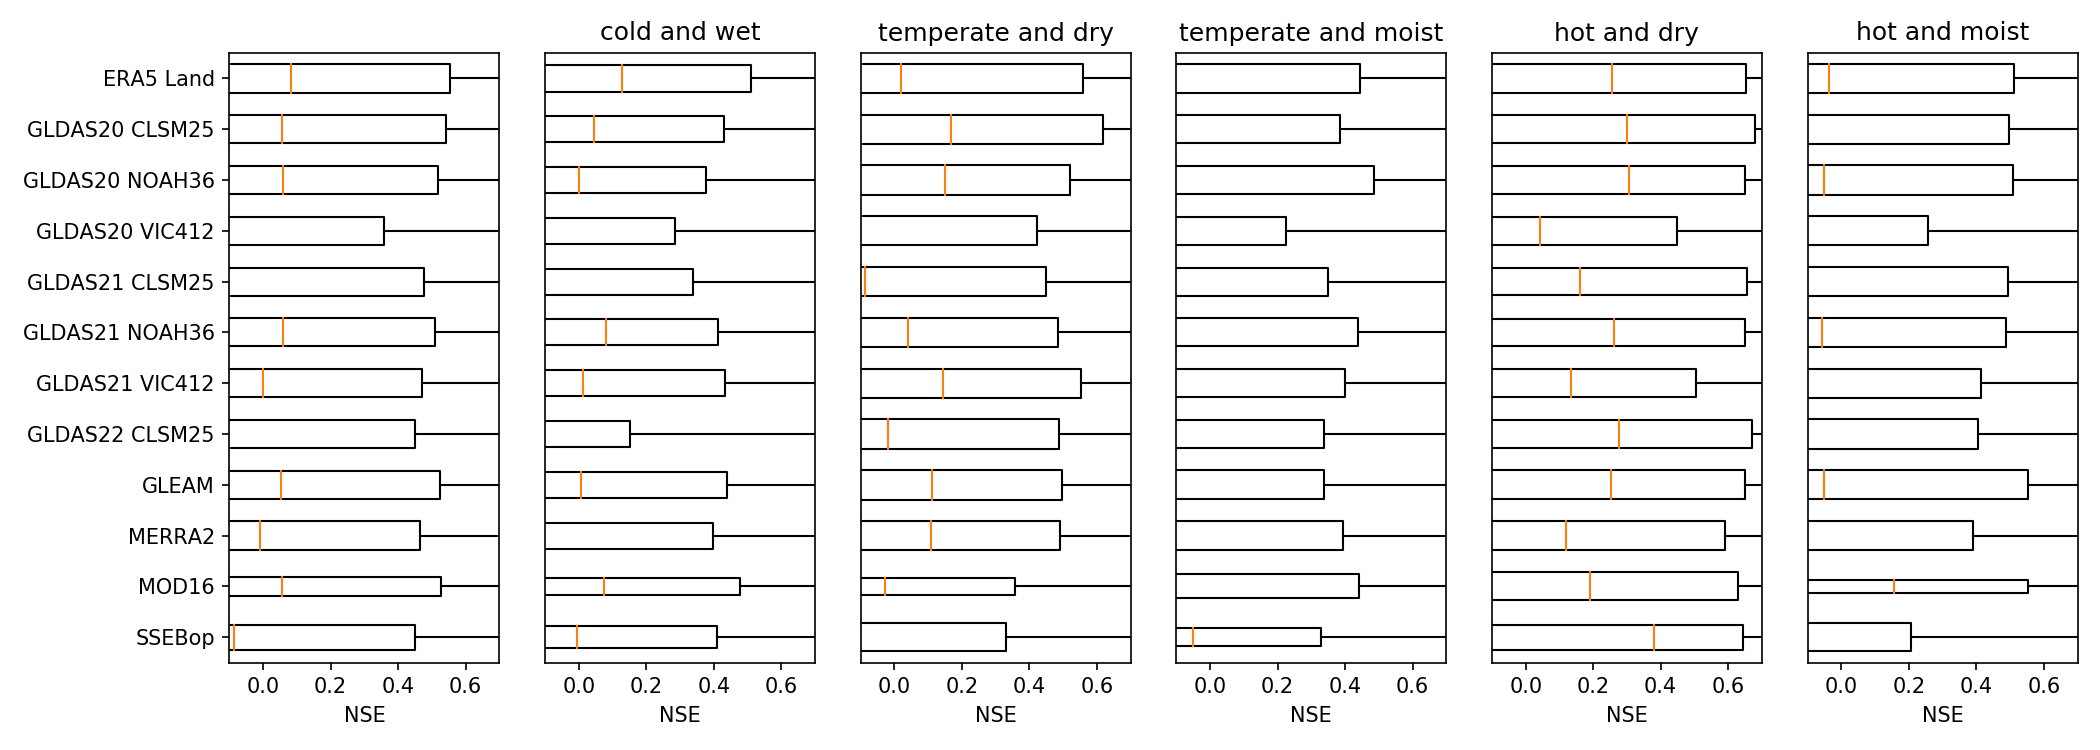

In [6]:
hydro_var_name='ET'

if hydro_var_name=='P':
    list_data=pd.Index(np.unique(data_P)).str[len(hydro_var_name)+1:]
if hydro_var_name=='ET':
    list_data=pd.Index(np.unique(data_ET)).str[len(hydro_var_name)+1:]
if hydro_var_name=='R':
    list_data=pd.Index(np.unique(data_R)).str[len(hydro_var_name)+1:]

plt.figure(figsize=(14,5))
for ic,climate in enumerate(['all',4,8,10,13,16]):
    plt.subplot(1,6,ic+1)
    for i,data in enumerate(list_data):
        select_datasets=[i for i in datasets if '{}_{}'.format(hydro_var_name,data) in i]

        if climate=='all':
            select_NSE_tab=NSE_tab[select_datasets]
        else:
            select_NSE_tab=NSE_tab.loc[basins['CLIMATE']==climate,select_datasets]
        temp=select_NSE_tab.values.flatten()
        nb_missing=np.sum(np.isnan(temp))/temp.shape[0]
        temp=temp[~np.isnan(temp)]
        plt.boxplot(temp,vert=False,widths=0.6-nb_missing*0.6,sym="",positions=[len(list_data)-i])
    plt.xlim([-0.1,0.7])
    plt.xlabel('NSE')
    
    if climate=='all':
        plt.yticks(np.arange(len(list_data),0,-1),list_data.str.replace('_',' '))
    else:
        plt.yticks([0],[''])
        plt.title(climate_labels[climate])
plt.tight_layout()
plt.show()

### Winner dataset

In [40]:
hydro_var_name='R'
data='GRUN'

winner=pd.DataFrame(np.nan*np.ones((NSE_tab.shape[0],2)),index=NSE_tab.index,columns=[data,'ref {}'.format(data)])

if hydro_var_name=='P':
    list_data=pd.Index(np.unique(data_P)).str[len(hydro_var_name)+1:]
if hydro_var_name=='ET':
    list_data=pd.Index(np.unique(data_ET)).str[len(hydro_var_name)+1:]
if hydro_var_name=='R':
    list_data=pd.Index(np.unique(data_R)).str[len(hydro_var_name)+1:]
    
select_datasets=[i for i in datasets if '{}_{}'.format(hydro_var_name,data) in i]
ref_datasets=list(set(datasets)-set(select_datasets))
select_NSE_tab=NSE_tab[select_datasets] # we select all columns containing 'data'
ref_NSE_tab=NSE_tab[ref_datasets] # all columns not containing 'data'

winner[data]=select_NSE_tab.median(axis=1)
winner['ref {}'.format(data)]=ref_NSE_tab.median(axis=1)

winner['{} - ref'.format(data)]=winner[data]-winner['ref {}'.format(data)]

In [41]:
basins=load_basins_data()

<IPython.core.display.Javascript object>


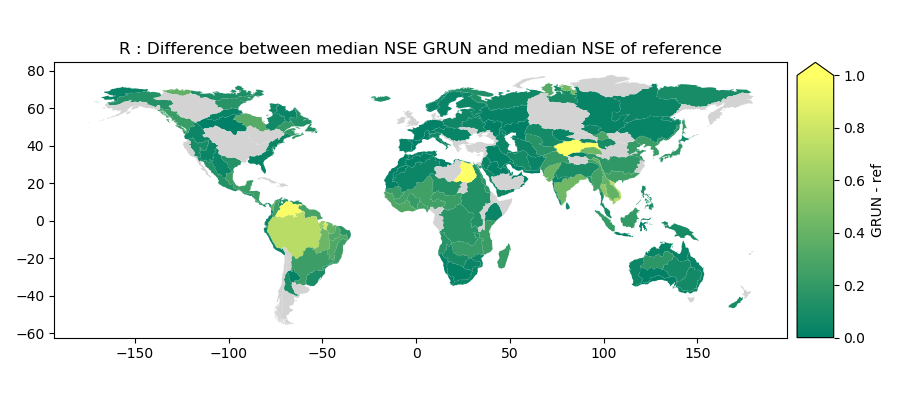

In [42]:
from matplotlib.cm import ScalarMappable

basins['{} - ref'.format(data)]=np.where(winner['{} - ref'.format(data)]<0,np.nan,winner['{} - ref'.format(data)])

my_cmap = plt.cm.get_cmap('viridis')

fig, ax = plt.subplots(figsize=(9,4))
ax.set_aspect('equal')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
basins.plot(ax=ax,column='{} - ref'.format(data),
                          legend=True,cax=cax,
                         vmin=0,
                     vmax=min(1.0,basins['{} - ref'.format(data)].max()),
                     #vmax=np.percentile(basins['{} - ref'.format(data)],98),
                          missing_kwds={"color": "lightgrey"},
                          legend_kwds={'label': "{} - ref".format(data),
                              'extend':'max'
                                      },
                         cmap='summer'
                    )

ax.set_title('{} : Difference between median NSE {} and median NSE of reference'.format(hydro_var_name,data)) 
plt.tight_layout()
plt.show()

In [49]:
basins.sort_values(by='{} - ref'.format(data),ascending=False)

,AREA,CLIMATE,geometry,GPCC - ref
HYBAS_ID,,,,
1030040280,2.572690e+05,16,"POLYGON ((24.22500 18.63750, 24.21744 18.63673...",0.406693
1030040310,2.436015e+06,17,"POLYGON ((-10.70417 23.62500, -10.71160 23.625...",0.375673
1030040210,1.342537e+06,17,"POLYGON ((9.10417 18.34167, 9.10328 18.34512, ...",0.346613
4030017020,7.732306e+05,18,"POLYGON ((105.23333 10.32083, 105.21424 10.321...",0.320514
4030033640,8.640621e+05,6,"POLYGON ((68.65833 33.72917, 68.65174 33.72881...",0.280017
...,...,...,...,...
7030034520,1.055756e+06,7,"POLYGON ((-89.97917 46.27083, -89.97973 46.281...",NaN
7030034530,1.986787e+05,7,"MULTIPOLYGON (((-63.91667 46.67917, -63.91610 ...",NaN
7030073620,5.215250e+05,8,"POLYGON ((-114.93750 37.72917, -114.93785 37.7...",NaN


# Differences between combinations in a basin

In [2]:
def decompose_combination(comb):
    i1=comb.find('ET_')
    data_P=comb[2:i1-1]
    i2=comb[i1:].find('R_')
    data_ET=comb[i1+3:i1+i2-1]
    i3=comb[i1+i2:].find('TWS_')
    data_R=comb[i1+i2+2:i1+i2+i3-1]
    return data_P,data_ET,data_R

In [3]:
def get_Afilter(data_P,data_ET,data_R,data_TWS):
    TWS_month=pd.read_csv('../results/hydrology/TWS_{}_monthly_filtered.csv'.format(data_TWS),index_col=[0])
    P_month=pd.read_csv('../results/hydrology/P_{}_monthly_filtered.csv'.format(data_P),index_col=[0])
    ET_month=pd.read_csv('../results/hydrology/ET_{}_monthly_filtered.csv'.format(data_ET),index_col=[0])
    R_month=pd.read_csv('../results/hydrology/R_{}_monthly_filtered.csv'.format(data_R),index_col=[0])
    time_idx=pd.date_range(date(2003,3,1),date(2014,12,1),freq='SM')[::2]

    P_filter=P_month.loc[basin_id,['P_{} {}'.format(data_P,d.date()) for d in time_idx]]
    ET_filter=ET_month.loc[basin_id,['ET_{} {}'.format(data_ET,d.date()) for d in time_idx]]
    R_filter=R_month.loc[basin_id,['R_{} {}'.format(data_R,d.date()) for d in time_idx]]
    TWSC_filter=TWS_month.loc[basin_id,['TWS_{} {}'.format(data_TWS,d.date()) for d in time_idx]]

    P_filter.index=time_idx
    ET_filter.index=time_idx
    R_filter.index=time_idx
    TWSC_filter.index=time_idx
    
    fillingP=(np.sum(np.isnan(P_filter))==0)
    fillingET=(np.sum(np.isnan(ET_filter))==0)
    fillingR=(np.sum(np.isnan(R_filter))==0)
    fillingTWS=(np.sum(np.isnan(TWSC_filter))==0)

    if fillingP&fillingET&fillingR&fillingTWS: # if this basin is entirely covered by all datasets, proceed, otherwise the loop ends
        A_filter=pd.Series(P_filter.values-ET_filter.values-R_filter.values,index=time_idx)
    else:
        print('This basin is not entirely covered')
    return P_filter,ET_filter,R_filter,TWSC_filter,A_filter

In [10]:
def get_TWS_uncertainty(data_TWS):
    TWS_month=pd.read_csv('../results/hydrology/TWS_{}_monthly_filtered.csv'.format(data_TWS),index_col=[0])
    dTWS_month=pd.read_csv('../results/hydrology/TWS_uncertainty_{}_monthly_filtered.csv'.format(data_TWS),index_col=[0])
    time_idx=pd.date_range(date(2003,3,1),date(2014,12,1),freq='SM')[::2]
    
    TWSC_filter=TWS_month.loc[basin_id,['TWS_{} {}'.format(data_TWS,d.date()) for d in time_idx]]
    TWSC_filter.index=time_idx
    
    dTWSC_filter=dTWS_month.loc[basin_id,['TWS_uncertainty_{} {}'.format(data_TWS,d.date()) for d in time_idx]]
    dTWSC_filter.index=time_idx

    return TWSC_filter,dTWSC_filter

In [32]:
%matplotlib notebook

basins=load_basins_data()
Nbasins=basins.shape[0]
Ndatasets=1080
data_TWS='GRACE_JPL_mascons'

NSE_tab=pd.read_csv("../results/water_budget/NSE_tab_{}basins_{}datasets_{}.csv".format(Nbasins,Ndatasets,data_TWS),index_col=[0])
datasets=NSE_tab.columns

<IPython.core.display.Javascript object>


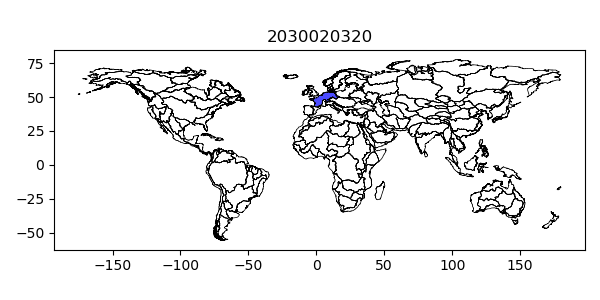

In [5]:
basin_id=2030020320

fig, ax = plt.subplots(figsize=(6,3))
ax.set_aspect('equal')
basins.boundary.plot(ax=ax,color='black',linewidth=0.5)
basins.loc[[basin_id],'geometry'].plot(ax=ax, color='blue',alpha=0.7)
plt.title(basin_id)
plt.tight_layout()
plt.show()

In [6]:
comb1=NSE_tab.loc[basin_id].sort_values(ascending=False).index[0]
data_P,data_ET,data_R=decompose_combination(comb1)

P_filter,ET_filter,R_filter,TWSC_filter,A_filter=get_Afilter(data_P,data_ET,data_R,data_TWS)

<IPython.core.display.Javascript object>


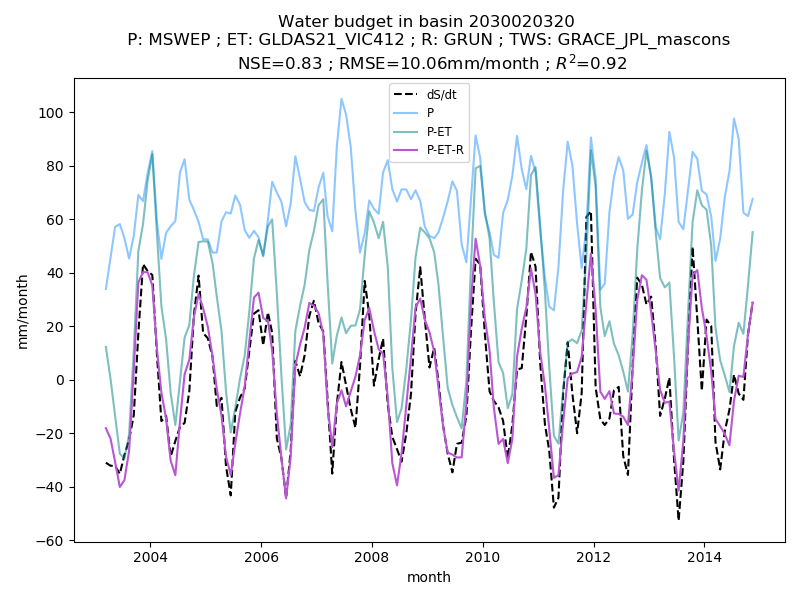

In [7]:
plt.figure(figsize=(8,6))
plt.plot(TWSC_filter,'k--',label='dS/dt')
plt.plot(P_filter,alpha=0.5,color='dodgerblue',label='P')
plt.plot(P_filter-ET_filter,alpha=0.5,color='teal',label='P-ET')
plt.plot(A_filter,color='mediumorchid',label='P-ET-R')
plt.xlabel('month')
plt.ylabel('mm/month')
plt.legend(fontsize='small')
plt.title('Water budget in basin {} \n P: {} ; ET: {} ; R: {} ; TWS: {} \n NSE={:.2f} ; RMSE={:.2f}mm/month ; $R^2$={:.2f}'.format(basin_id,
                            data_P,data_ET,data_R,data_TWS,compute_NSE(A_filter,TWSC_filter),
                            compute_RMSE(A_filter,TWSC_filter),A_filter.corr(TWSC_filter)))
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


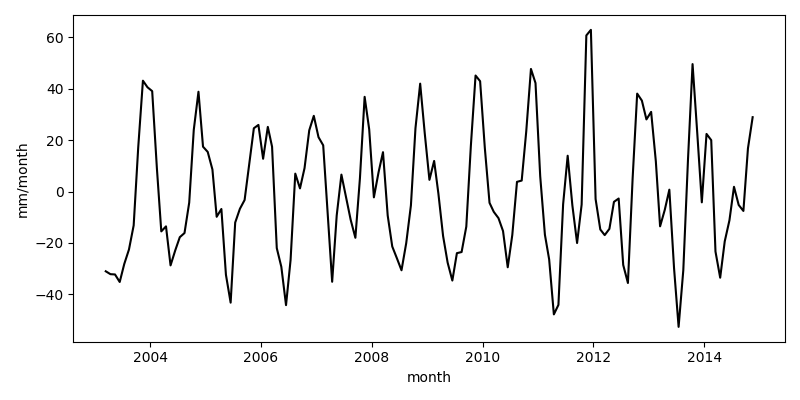

In [32]:
plt.figure(figsize=(8,4))
plt.plot(TWSC_filter,color='k')
plt.xlabel('month')
plt.ylabel('mm/month')
plt.tight_layout()
plt.show()

In [30]:
TWS_month=pd.read_csv('../results/hydrology/TWS_{}_monthly.csv'.format(data_TWS),index_col=[0])
time_idx=pd.date_range(date(2003,3,1),date(2014,12,1),freq='SM')[::2]
TWS_filter=TWS_month.loc[basin_id,['TWS_{} {}'.format(data_TWS,d.date()) for d in time_idx]]
TWS_filter.index=time_idx

Reconstruction differences with the best combinations

<IPython.core.display.Javascript object>


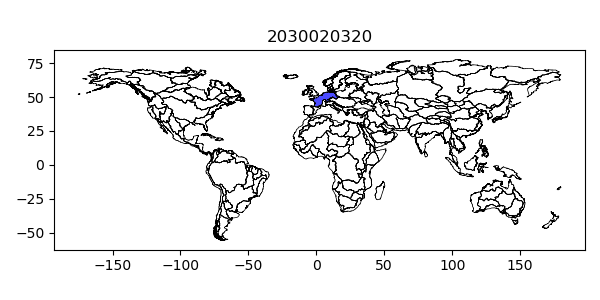

In [11]:
basin_id=2030020320

fig, ax = plt.subplots(figsize=(6,3))
ax.set_aspect('equal')
basins.boundary.plot(ax=ax,color='black',linewidth=0.5)
basins.loc[[basin_id],'geometry'].plot(ax=ax, color='blue',alpha=0.7)
plt.title(basin_id)
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


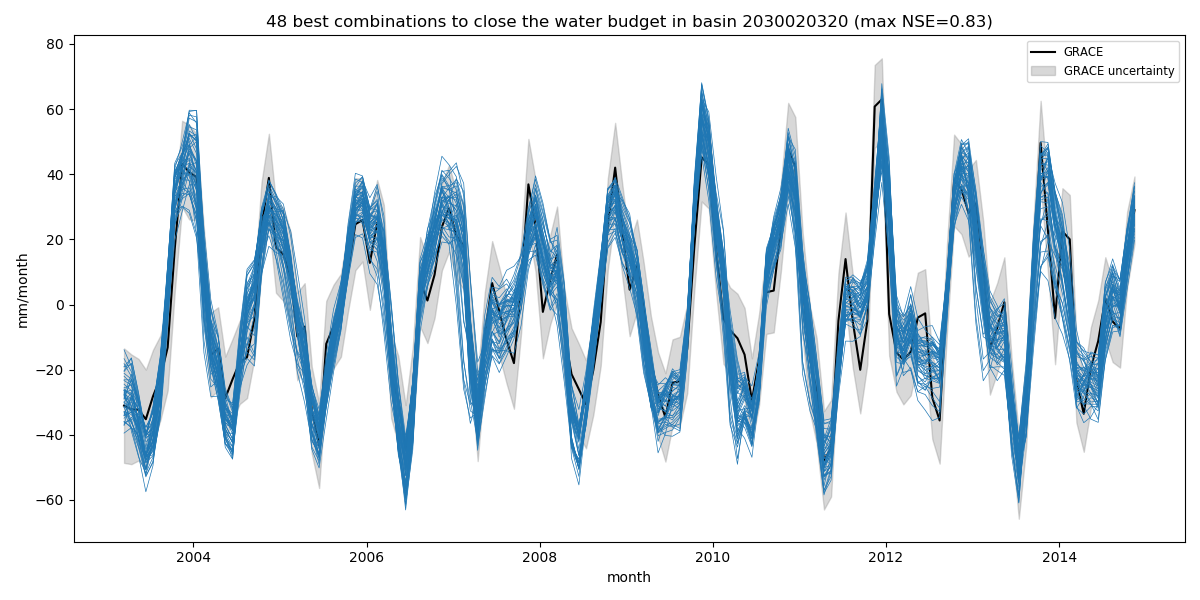

In [34]:
NSE_tab['max NSE']=np.nanmax(NSE_tab,axis=1)
TWSC_filter,dTWSC_filter=get_TWS_uncertainty(data_TWS)
nb_comb=min(np.sum(NSE_tab.loc[basin_id,'max NSE']-NSE_tab.loc[basin_id]<=0.1),50) # number of combinations with a cost <= 0.1

plt.figure(figsize=(12,6))

plt.plot(TWSC_filter,'k',label='GRACE')
plt.fill_between(TWSC_filter.index,TWSC_filter-dTWSC_filter,TWSC_filter+dTWSC_filter,
                 color='grey',alpha=0.3,label='GRACE uncertainty')

for comb in NSE_tab.loc[basin_id,datasets].sort_values(ascending=False).index[:nb_comb]:
    data_P,data_ET,data_R=decompose_combination(comb)
    P_filter,ET_filter,R_filter,TWSC_filter,A_filter=get_Afilter(data_P,data_ET,data_R,data_TWS)
    plt.plot(A_filter,color='tab:blue',linewidth=0.5)
    
plt.xlabel('month')
plt.ylabel('mm/month')
plt.legend(fontsize='small')
plt.title('{} best combinations to close the water budget in basin {} (max NSE={:.2f})'.format(nb_comb,
                                                basin_id,NSE_tab.loc[basin_id,'max NSE']))
plt.tight_layout()
plt.show()

In [16]:
TWSC_filter-dTWSC_filter

2003-03-15   -48.619285
2003-04-15   -49.010589
2003-05-15   -47.883345
2003-06-15   -50.436854
2003-07-15   -42.470207
                ...    
2014-07-15   -10.815251
2014-08-15   -17.669910
2014-09-15   -19.372559
2014-10-15     5.131430
2014-11-15    18.610904
Freq: 2SM-15, Name: 2030020320, Length: 141, dtype: float64

In [14]:
dTWSC_filter

2003-03-15    17.568189
2003-04-15    16.833819
2003-05-15    15.599214
2003-06-15    15.221295
2003-07-15    14.268739
                ...    
2014-07-15    12.669834
2014-08-15    12.440689
2014-09-15    11.820579
2014-10-15    11.675192
2014-11-15    10.351896
Freq: 2SM-15, Name: 2030020320, Length: 141, dtype: float64

# Percentage months within GRACE uncertainty

In [13]:
%matplotlib notebook

basins=load_basins_data()
Nbasins=basins.shape[0]
Ndatasets=1430
data_TWS='GRACE_JPL_mascons'

GRACE_uncertainty_tab=pd.read_csv("../results/water_budget/GRACE_uncertainty_tab_{}basins_{}datasets_{}.csv".format(Nbasins,Ndatasets,data_TWS),index_col=[0])

<IPython.core.display.Javascript object>


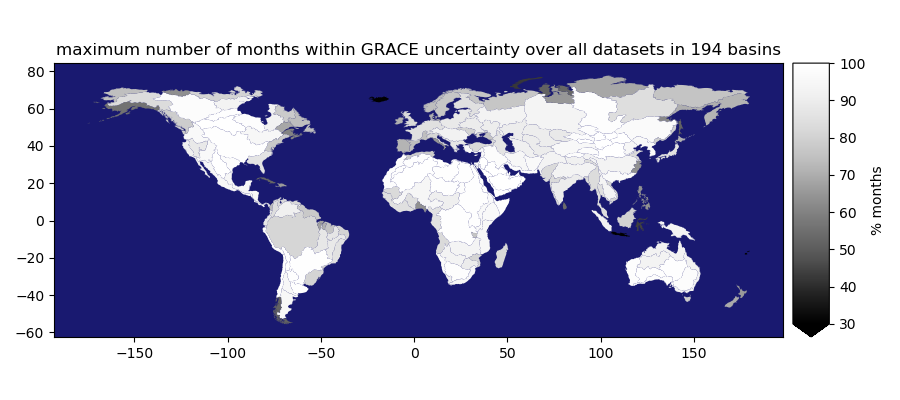

In [18]:
basins_plot=basins.loc[GRACE_uncertainty_tab.index].copy()
basins_plot['max months']=np.nanmax(GRACE_uncertainty_tab,axis=1)

fig, ax = plt.subplots(figsize=(9,4))
ax.set_aspect('equal')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
#basins.plot(ax=ax,color='white',edgecolor='black',linewidth=0.5)
basins_plot.plot(ax=ax,column='max months',
                 cmap=plt.cm.get_cmap('Greys_r'),
                 vmin=30,
                 vmax=100,
                 legend=True,cax=cax,
                legend_kwds={'label': "% months",
                              'extend':'min'
                          },)
ax.set_facecolor('midnightblue')
ax.set_title('maximum number of months within GRACE uncertainty over all datasets in {} basins'.format(NSE_tab.shape[0]))
plt.tight_layout()
plt.show()

In [26]:
np.max(np.nanmax(GRACE_uncertainty_tab,axis=1))

100.0

<IPython.core.display.Javascript object>


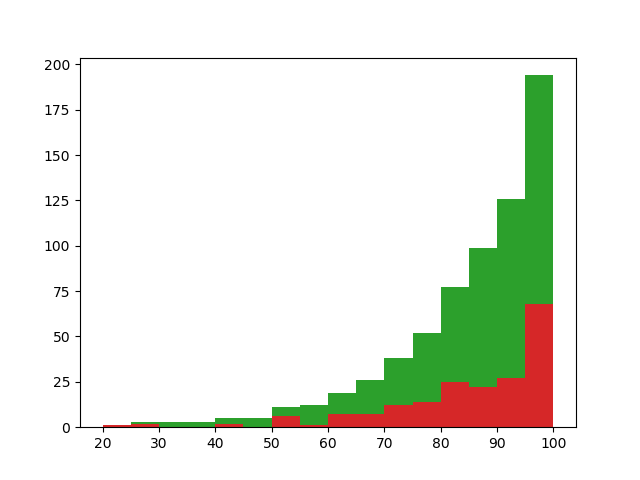

In [27]:
plt.figure()
plt.hist(np.nanmax(GRACE_uncertainty_tab,axis=1),bins=np.arange(20,105,5))
plt.show()

In [30]:
plt.hist(np.nanmax(GRACE_uncertainty_tab,axis=1),bins=np.arange(20,105,5))

(array([ 1.,  2.,  0.,  0.,  2.,  0.,  6.,  1.,  7.,  7., 12., 14., 25.,
        22., 27., 68.]),
 array([ 20,  25,  30,  35,  40,  45,  50,  55,  60,  65,  70,  75,  80,
         85,  90,  95, 100]),
 <a list of 16 Patch objects>)

In [36]:
np.sum(np.nanmax(GRACE_uncertainty_tab,axis=1)>=75)

156

<IPython.core.display.Javascript object>


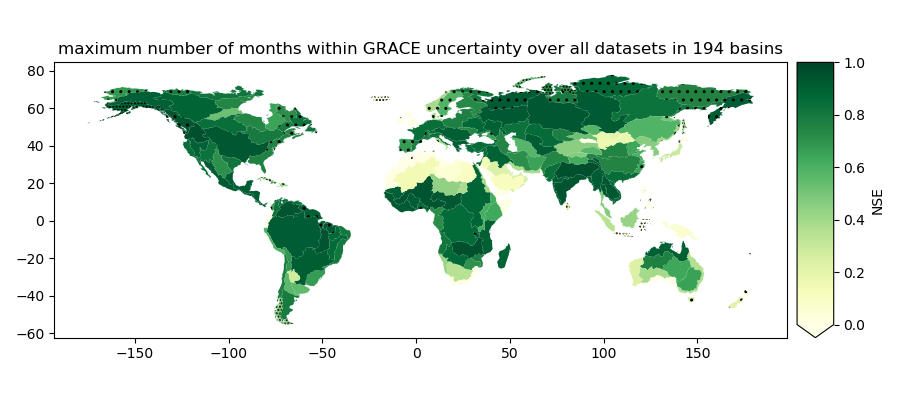

In [62]:
basins_plot=basins.loc[GRACE_uncertainty_tab.index].copy()
basins_plot['max months']=np.nanmax(GRACE_uncertainty_tab,axis=1)
basins_plot['max NSE']=np.nanmax(NSE_tab,axis=1)

fig, ax = plt.subplots(figsize=(9,4))
ax.set_aspect('equal')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
basins_plot.plot(ax=ax,column='max NSE',
                 cmap=plt.cm.get_cmap('YlGn'),
                 vmin=0,vmax=1,
                 legend=True,cax=cax,
                legend_kwds={'label': "NSE",
                              'extend':'min'
                          },)

basins_plot.loc[basins_plot['max months']<=60].plot(ax=ax,
                                                    color='grey',alpha=0,hatch='.....')
basins_plot.loc[(basins_plot['max months']>60)&(basins_plot['max months']<=80)].plot(ax=ax,
                                                                        color='white',alpha=0,hatch='..')
ax.set_title('maximum number of months within GRACE uncertainty over all datasets in {} basins'.format(NSE_tab.shape[0]))
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


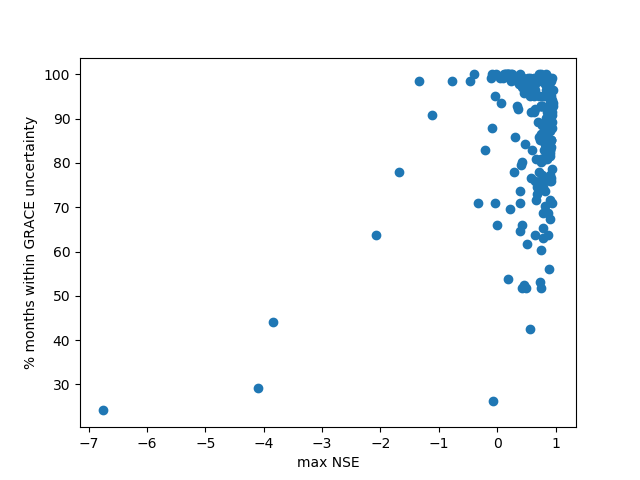

In [64]:
plt.figure()
plt.scatter(basins_plot['max NSE'],basins_plot['max months'])
plt.xlabel('max NSE')
plt.ylabel('% months within GRACE uncertainty')
plt.show()